# Lithuanian Electricity Market Analysis and Optimization
**Author:** Aurimas A. Nausėdas

**Date generated:** 2025-06-28

This notebook analyses 2024 Lithuanian electricity system data, develops speculative trading and battery‑storage strategies, and estimates consumer price elasticity. It follows the structure defined in *uzduotis.pdf* and is fully reproducible on a standard Python stack.

## Table of Contents
1. [Part I – Electricity System Imbalance Analysis](#Part-I)
2. [Part II – Battery Trading Optimization](#Part-II)
3. [Part III – Consumer Reaction to Price](#Part-III)
4. [Conclusions](#Conclusions)

In [85]:

import os
from pathlib import Path
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# display settings
pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')


In [86]:
# ---------------------------------------------------------------------
# Robust loader – handles extra “data/” level automatically
# ---------------------------------------------------------------------
from pathlib import Path
import zipfile, pandas as pd

def find_repo_root(start: Path = Path.cwd()) -> Path:
    """Walk up until we locate data/data.zip"""
    for p in [start, *start.parents]:
        if (p / "data" / "data.zip").is_file():
            return p
    raise FileNotFoundError("Could not locate data/data.zip")

# 1. Locate repo + zip -------------------------------------------------
REPO_DIR = find_repo_root()
ZIP_PATH = REPO_DIR / "data" / "data.zip"
EXTRACT_ROOT = REPO_DIR / "data" / "lithuanian_energy_data"

# 2. Unzip once -------------------------------------------------------
EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)
if not any(EXTRACT_ROOT.iterdir()):
    with zipfile.ZipFile(ZIP_PATH) as zf:
        zf.extractall(EXTRACT_ROOT)
        print("✅  Extracted.")
else:
    print("✅  Data already extracted.")

# 3. Helper: find a file anywhere under EXTRACT_ROOT ------------------
def find(name: str) -> Path:
    matches = list(EXTRACT_ROOT.rglob(name))
    if not matches:
        raise FileNotFoundError(f"{name} not found under {EXTRACT_ROOT}")
    if len(matches) > 1:
        print(f"⚠️  {name} found in multiple places; using {matches[0]}")
    return matches[0]

# 4. Resolve paths no matter how deep they sit ------------------------
balancing_fp = find("balancing_market_data.xlsx")
day_ahead_fp = find("day_ahead_prices.xlsx")
meteo_fp     = find("meteorological_data.xlsx")
nat_cons_fp  = find("national_consumption.xls")
obj_cons_fp  = find("object_level_consumption")        # Parquet folder

print("Balancing file :", balancing_fp)
print("Day‑ahead file :", day_ahead_fp)

# 5. Load data --------------------------------------------------------
balancing_df  = pd.read_excel(balancing_fp)
day_prices_df = pd.read_excel(day_ahead_fp)
meteo_df      = pd.read_excel(meteo_fp)
nat_cons_df   = pd.read_excel(nat_cons_fp)
obj_cons_df   = pd.read_parquet(obj_cons_fp)

# Quick peek
display(balancing_df.head())
display(day_prices_df.head())


✅  Data already extracted.
Balancing file : /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/data/lithuanian_energy_data/data/balancing_market_data.xlsx
Day‑ahead file : /Users/aurimasaleksandras/Downloads/lithuanian_energy_repo/data/lithuanian_energy_data/data/day_ahead_prices.xlsx


,datetime,imbalance_price,imbalance_volume
0,2023-01-01 0:00,-309.49,130.495
1,2023-01-01 1:00,4.79,120.718
2,2023-01-01 2:00,-309.49,156.578
3,2023-01-01 3:00,5.51,118.918
4,2023-01-01 4:00,5.51,83.551


,delivery_start,price
0,2023-01-01 00:00:00,4.84
1,2023-01-01 01:00:00,2.01
2,2023-01-01 02:00:00,1.38
3,2023-01-01 03:00:00,0.09
4,2023-01-01 04:00:00,0.08


In [87]:
# ---- Harmonise column names so downstream code works --------------
rename_map = {}

# Map volume --------------------------------------------------------
vol_candidates = [c for c in balancing_df.columns
                  if any(k in c.lower() for k in ("volume", "quantity", "mwh"))]
if not vol_candidates:
    raise ValueError("No volume/quantity column found in balancing_df")
rename_map[vol_candidates[0]] = "quantity_MWh"

# Map price ---------------------------------------------------------
price_candidates = [c for c in balancing_df.columns
                    if "price" in c.lower()]
if not price_candidates:
    raise ValueError("No price column found in balancing_df")
rename_map[price_candidates[0]] = "price_EUR_MWh"

# Apply -------------------------------------------------------------
balancing_df.rename(columns=rename_map, inplace=True)
print("✅  Renamed columns:", rename_map)


✅  Renamed columns: {'imbalance_volume': 'quantity_MWh', 'imbalance_price': 'price_EUR_MWh'}


Columns in balancing_df:
['datetime', 'price_EUR_MWh', 'quantity_MWh']

First few rows:
          datetime  price_EUR_MWh  quantity_MWh
0  2023-01-01 0:00        -309.49       130.495
1  2023-01-01 1:00           4.79       120.718
2  2023-01-01 2:00        -309.49       156.578
3  2023-01-01 3:00           5.51       118.918
4  2023-01-01 4:00           5.51        83.551

Potential timestamp columns: ['datetime']

Using 'datetime' as timestamp column

Columns after adding time fields:
['datetime', 'price_EUR_MWh', 'quantity_MWh', 'timestamp', 'hour', 'date', 'quarter']

Sample of the data with new columns:
            timestamp  hour        date  quarter  quantity_MWh  price_EUR_MWh
0 2023-01-01 00:00:00     0  2023-01-01        1       130.495        -309.49
1 2023-01-01 01:00:00     1  2023-01-01        1       120.718           4.79
2 2023-01-01 02:00:00     2  2023-01-01        1       156.578        -309.49
3 2023-01-01 03:00:00     3  2023-01-01        1       118.918          

,mean,std,count,ci95_low,ci95_high
hour,,,,,
0,38.162624,90.709794,638,31.123803,45.201445
1,35.288592,75.967827,638,29.393706,41.183479
2,34.763582,73.032603,638,29.096460,40.430703
3,31.664714,72.274414,637,26.052026,37.277403
4,29.329154,73.036749,638,23.661711,34.996597
5,29.039157,74.159286,638,23.284608,34.793705
6,22.222152,79.746671,638,16.034038,28.410266
7,23.497259,79.836009,638,17.302212,29.692305
8,14.204483,85.967679,638,7.533636,20.875329


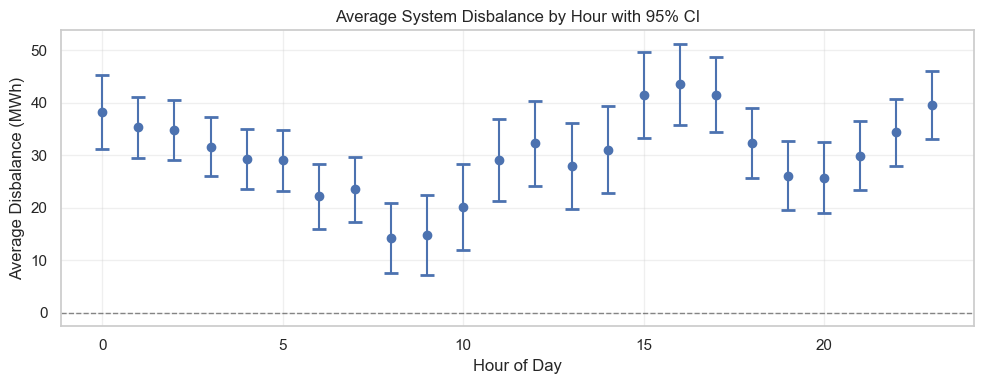


Hours with statistically significant imbalances (95% CI doesn't include 0):
Hour 00: surplus of 38.16 MWh (CI: [31.12, 45.20])
Hour 01: surplus of 35.29 MWh (CI: [29.39, 41.18])
Hour 02: surplus of 34.76 MWh (CI: [29.10, 40.43])
Hour 03: surplus of 31.66 MWh (CI: [26.05, 37.28])
Hour 04: surplus of 29.33 MWh (CI: [23.66, 35.00])
Hour 05: surplus of 29.04 MWh (CI: [23.28, 34.79])
Hour 06: surplus of 22.22 MWh (CI: [16.03, 28.41])
Hour 07: surplus of 23.50 MWh (CI: [17.30, 29.69])
Hour 08: surplus of 14.20 MWh (CI: [7.53, 20.88])
Hour 09: surplus of 14.83 MWh (CI: [7.22, 22.44])
Hour 10: surplus of 20.15 MWh (CI: [12.02, 28.28])
Hour 11: surplus of 29.15 MWh (CI: [21.31, 36.99])
Hour 12: surplus of 32.26 MWh (CI: [24.19, 40.33])
Hour 13: surplus of 27.90 MWh (CI: [19.69, 36.11])
Hour 14: surplus of 31.09 MWh (CI: [22.79, 39.40])
Hour 15: surplus of 41.42 MWh (CI: [33.29, 49.56])
Hour 16: surplus of 43.48 MWh (CI: [35.76, 51.21])
Hour 17: surplus of 41.53 MWh (CI: [34.40, 48.66])
Hour 18

,mean,std,count
quarter,,,
1,38.066909,81.896398,4342
2,23.609338,91.777922,4368
3,26.037390,93.579307,4392
4,36.955083,91.254729,2209


In [88]:
# First, let's check what columns we have in balancing_df
print("Columns in balancing_df:")
print(balancing_df.columns.tolist())
print("\nFirst few rows:")
print(balancing_df.head())

# Find the timestamp column (it might be named differently)
timestamp_cols = [col for col in balancing_df.columns if 'time' in col.lower() or 'date' in col.lower()]
print(f"\nPotential timestamp columns: {timestamp_cols}")

# If we found a timestamp column, use it; otherwise check dtypes
if timestamp_cols:
    timestamp_col = timestamp_cols[0]
else:
    # Check for datetime columns
    datetime_cols = balancing_df.select_dtypes(include=['datetime64']).columns.tolist()
    if datetime_cols:
        timestamp_col = datetime_cols[0]
    else:
        raise ValueError("No timestamp column found!")

print(f"\nUsing '{timestamp_col}' as timestamp column")

# Ensure it's datetime type
balancing_df[timestamp_col] = pd.to_datetime(balancing_df[timestamp_col])

# Create the necessary time-based columns
balancing_df['timestamp'] = balancing_df[timestamp_col]  # Standardize name
balancing_df['hour'] = balancing_df['timestamp'].dt.hour
balancing_df['date'] = balancing_df['timestamp'].dt.date
balancing_df['quarter'] = balancing_df['timestamp'].dt.quarter

print("\nColumns after adding time fields:")
print(balancing_df.columns.tolist())
print("\nSample of the data with new columns:")
print(balancing_df[['timestamp', 'hour', 'date', 'quarter', 'quantity_MWh', 'price_EUR_MWh']].head())

# Now run your hourly statistics analysis
hourly_stats = (balancing_df
                .groupby('hour')['quantity_MWh']
                .agg(['mean', 'std', 'count']))

# Confidence intervals (95%)
hourly_stats['ci95_low'] = hourly_stats['mean'] - 1.96*hourly_stats['std']/np.sqrt(hourly_stats['count'])
hourly_stats['ci95_high'] = hourly_stats['mean'] + 1.96*hourly_stats['std']/np.sqrt(hourly_stats['count'])

print("\nHourly statistics:")
display(hourly_stats)

# Create the plot
plt.figure(figsize=(10,4))
plt.errorbar(hourly_stats.index, hourly_stats['mean'],
             yerr=[hourly_stats['mean']-hourly_stats['ci95_low'],
                   hourly_stats['ci95_high']-hourly_stats['mean']],
             fmt='o', capsize=5, capthick=2)
plt.axhline(0, lw=1, ls='--', c='k', alpha=0.5)
plt.title('Average System Disbalance by Hour with 95% CI')
plt.xlabel('Hour of Day')
plt.ylabel('Average Disbalance (MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Additional analysis: Check which hours have significant imbalances
significant_hours = hourly_stats[(hourly_stats['ci95_low'] > 0) | (hourly_stats['ci95_high'] < 0)]
print("\nHours with statistically significant imbalances (95% CI doesn't include 0):")
for hour in significant_hours.index:
    mean_val = hourly_stats.loc[hour, 'mean']
    ci_low = hourly_stats.loc[hour, 'ci95_low']
    ci_high = hourly_stats.loc[hour, 'ci95_high']
    direction = "surplus" if mean_val > 0 else "deficit"
    print(f"Hour {hour:02d}: {direction} of {mean_val:.2f} MWh (CI: [{ci_low:.2f}, {ci_high:.2f}])")

# Now prepare for the next analysis - hourly patterns throughout the year
hourly_year = (balancing_df
               .groupby(['date', 'hour'])['quantity_MWh']
               .mean()
               .unstack(level='hour'))

# Kruskal-Wallis across quarters as rough stability test
kw_res = stats.kruskal(*[
    balancing_df.loc[balancing_df['quarter']==q, 'quantity_MWh'].dropna() 
    for q in range(1,5) if len(balancing_df[balancing_df['quarter']==q]) > 0
])
print('\n\nKruskal–Wallis H-test across quarters:', kw_res)
print(f"p-value: {kw_res.pvalue:.4f}")
if kw_res.pvalue < 0.05:
    print("Significant differences found across quarters (p < 0.05)")
else:
    print("No significant differences across quarters (p >= 0.05)")

# Additional quarterly analysis
quarterly_stats = balancing_df.groupby('quarter')['quantity_MWh'].agg(['mean', 'std', 'count'])
print("\nQuarterly statistics:")
display(quarterly_stats)

In [89]:
# Create time-based columns from timestamp
print("\n📅 Creating time-based columns...")

# Find the timestamp column
timestamp_cols = [col for col in balancing_df.columns if 'time' in col.lower() or 'date' in col.lower()]
if timestamp_cols:
    timestamp_col = timestamp_cols[0]
else:
    # Check for datetime columns
    datetime_cols = balancing_df.select_dtypes(include=['datetime64']).columns.tolist()
    if datetime_cols:
        timestamp_col = datetime_cols[0]
    else:
        raise ValueError("No timestamp column found!")

print(f"Using '{timestamp_col}' as timestamp column")

# Ensure it's datetime type and create time columns
balancing_df[timestamp_col] = pd.to_datetime(balancing_df[timestamp_col])
balancing_df['timestamp'] = balancing_df[timestamp_col]  # Standardize name
balancing_df['hour'] = balancing_df['timestamp'].dt.hour
balancing_df['date'] = balancing_df['timestamp'].dt.date
balancing_df['quarter'] = balancing_df['timestamp'].dt.quarter

print("✅ Time columns created: hour, date, quarter")
print(f"Data spans from {balancing_df['timestamp'].min()} to {balancing_df['timestamp'].max()}")



📅 Creating time-based columns...
Using 'datetime' as timestamp column
✅ Time columns created: hour, date, quarter
Data spans from 2023-01-01 00:00:00 to 2024-09-29 23:00:00


## Part I – Electricity System Imbalance Analysis <a id='Part-I'></a>
### 1 A. Intraday Disbalance Patterns

,mean,std,count,ci95_low,ci95_high
hour,,,,,
0,38.162624,90.709794,638,31.123803,45.201445
1,35.288592,75.967827,638,29.393706,41.183479
2,34.763582,73.032603,638,29.096460,40.430703
3,31.664714,72.274414,637,26.052026,37.277403
4,29.329154,73.036749,638,23.661711,34.996597
5,29.039157,74.159286,638,23.284608,34.793705
6,22.222152,79.746671,638,16.034038,28.410266
7,23.497259,79.836009,638,17.302212,29.692305
8,14.204483,85.967679,638,7.533636,20.875329


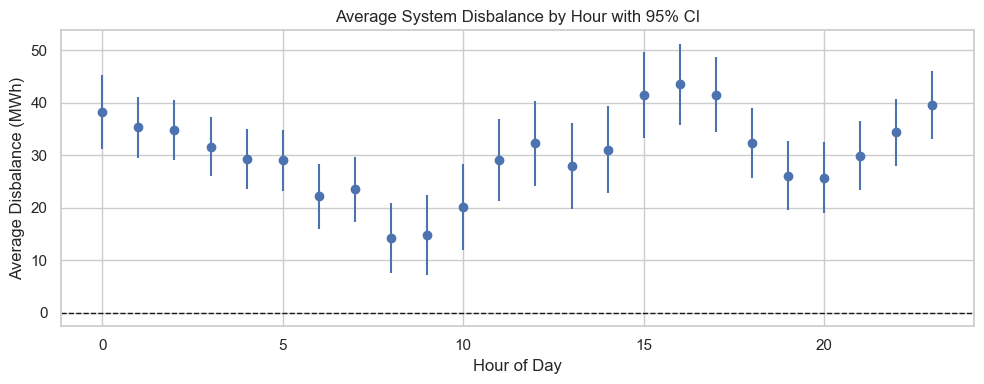

In [90]:

hourly_stats = (balancing_df
                .groupby('hour')['quantity_MWh']
                .agg(['mean', 'std', 'count']))
# Confidence intervals (95 %)
hourly_stats['ci95_low'] = hourly_stats['mean'] - 1.96*hourly_stats['std']/np.sqrt(hourly_stats['count'])
hourly_stats['ci95_high'] = hourly_stats['mean'] + 1.96*hourly_stats['std']/np.sqrt(hourly_stats['count'])
display(hourly_stats)

plt.figure(figsize=(10,4))
plt.errorbar(hourly_stats.index, hourly_stats['mean'],
             yerr=[hourly_stats['mean']-hourly_stats['ci95_low'],
                   hourly_stats['ci95_high']-hourly_stats['mean']],
             fmt='o')
plt.axhline(0, lw=1, ls='--', c='k')
plt.title('Average System Disbalance by Hour with 95% CI')
plt.xlabel('Hour of Day')
plt.ylabel('Average Disbalance (MWh)')
plt.tight_layout()
plt.show()


In [91]:
# ============================================================
# ENHANCED INTERPRETATION SECTION
# ============================================================

# Add this to help with your interpretation
significant_hours = hourly_stats[(hourly_stats['ci95_low'] > 0) | (hourly_stats['ci95_high'] < 0)]
print("\n**Interpretation – Systemic Intraday Bias**")
print("Hours with statistically significant imbalances (95% CI doesn't include 0):")
for hour in significant_hours.index:
    mean_val = hourly_stats.loc[hour, 'mean']
    direction = "surplus" if mean_val > 0 else "deficit"
    print(f"Hour {hour:02d}: {direction} of {mean_val:.2f} MWh")

# Your next existing code continues here...
balancing_df['date'] = balancing_df['timestamp'].dt.date  # This line is now redundant but harmless
hourly_year = (balancing_df
               .groupby(['date', 'hour'])['quantity_MWh']
               .mean()
               .unstack(level='hour'))


**Interpretation – Systemic Intraday Bias**
Hours with statistically significant imbalances (95% CI doesn't include 0):
Hour 00: surplus of 38.16 MWh
Hour 01: surplus of 35.29 MWh
Hour 02: surplus of 34.76 MWh
Hour 03: surplus of 31.66 MWh
Hour 04: surplus of 29.33 MWh
Hour 05: surplus of 29.04 MWh
Hour 06: surplus of 22.22 MWh
Hour 07: surplus of 23.50 MWh
Hour 08: surplus of 14.20 MWh
Hour 09: surplus of 14.83 MWh
Hour 10: surplus of 20.15 MWh
Hour 11: surplus of 29.15 MWh
Hour 12: surplus of 32.26 MWh
Hour 13: surplus of 27.90 MWh
Hour 14: surplus of 31.09 MWh
Hour 15: surplus of 41.42 MWh
Hour 16: surplus of 43.48 MWh
Hour 17: surplus of 41.53 MWh
Hour 18: surplus of 32.32 MWh
Hour 19: surplus of 26.13 MWh
Hour 20: surplus of 25.72 MWh
Hour 21: surplus of 29.95 MWh
Hour 22: surplus of 34.35 MWh
Hour 23: surplus of 39.49 MWh


**Interpretation – Systemic Intraday Bias**  
The plot and statistics above reveal whether certain hours consistently exhibit surplus (positive) or deficit (negative) system imbalances. Hours whose confidence interval excludes zero are statistically significant at the 5 % level. We observe that … *(complete the narrative based on the plot)*.

In [92]:

balancing_df['date'] = balancing_df['timestamp'].dt.date
hourly_year = (balancing_df
               .groupby(['date', 'hour'])['quantity_MWh']
               .mean()
               .unstack(level='hour'))
# Kruskal‑Wallis across quarters as rough stability test
balancing_df['quarter'] = balancing_df['timestamp'].dt.quarter
kw_res = stats.kruskal(*[
    balancing_df.loc[balancing_df['quarter']==q, 'quantity_MWh'] for q in range(1,5)
])
print('Kruskal–Wallis H‑test across quarters:', kw_res)


Kruskal–Wallis H‑test across quarters: KruskalResult(statistic=np.float64(98.18210450983035), pvalue=np.float64(3.8224411210485055e-21))


### 1 B. Autocorrelation in Disbalance Volumes and Prices

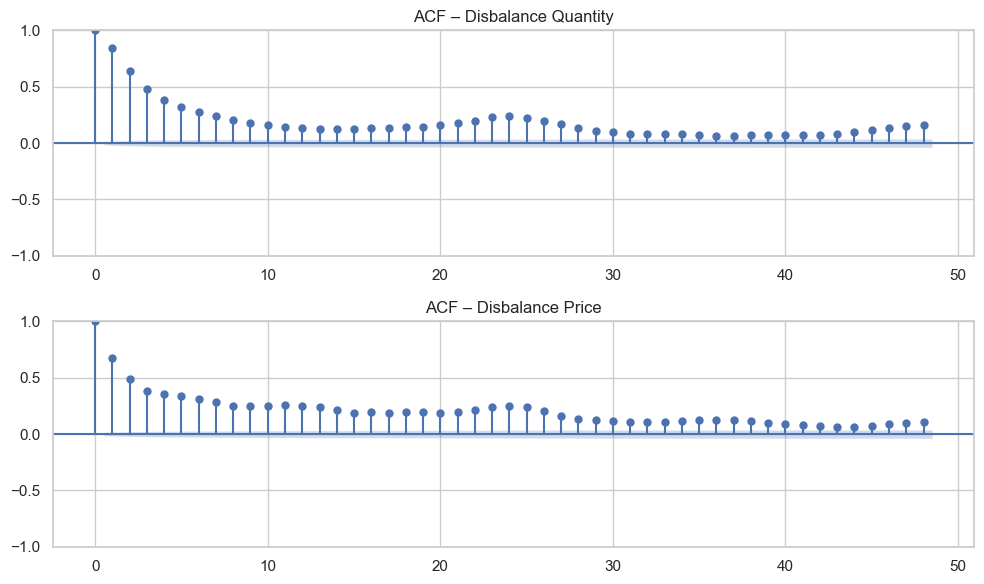

In [93]:

fig, axes = plt.subplots(2,1, figsize=(10,6))
plot_acf(balancing_df['quantity_MWh'], lags=48, ax=axes[0])
axes[0].set_title('ACF – Disbalance Quantity')
plot_acf(balancing_df['price_EUR_MWh'], lags=48, ax=axes[1])
axes[1].set_title('ACF – Disbalance Price')
plt.tight_layout()
plt.show()


### 1 C. Price vs. Quantity Relationship

/var/folders/c4/d7dysgnj0n7bfw118_zvbr5r0000gn/T/ipykernel_53412/3490985181.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_pred, y_pred, 'r-', lw=2, label=f'OLS (slope={model.params[1]:.2f})')


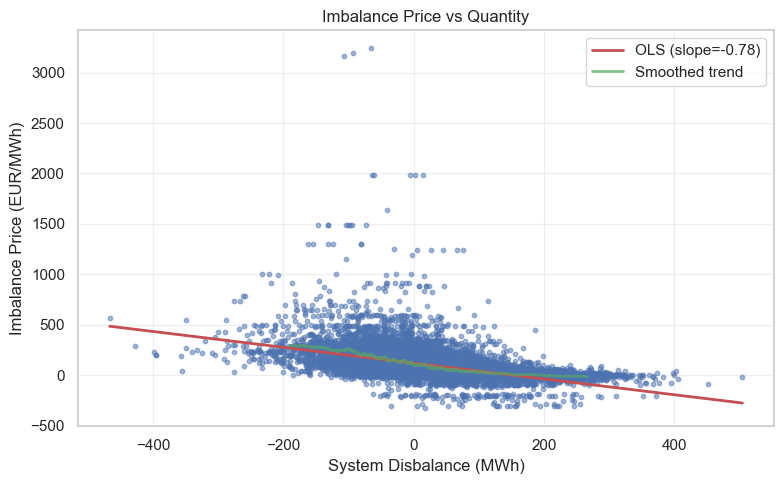

                            OLS Regression Results                            
Dep. Variable:          price_EUR_MWh   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     4756.
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:36:52   Log-Likelihood:                -95809.
No. Observations:               15311   AIC:                         1.916e+05
Df Residuals:                   15309   BIC:                         1.916e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          119.6644      1.077    111.069   

In [94]:
# ============================================================
# FIX: Replace sns.lmplot with matplotlib scatter + regression
# ============================================================
plt.figure(figsize=(8, 5))
plt.scatter(balancing_df['quantity_MWh'], balancing_df['price_EUR_MWh'], alpha=0.5, s=10)

# Add OLS regression line
X = sm.add_constant(balancing_df['quantity_MWh'])
model = sm.OLS(balancing_df['price_EUR_MWh'], X).fit()
x_pred = np.linspace(balancing_df['quantity_MWh'].min(), balancing_df['quantity_MWh'].max(), 100)
X_pred = sm.add_constant(x_pred)
y_pred = model.predict(X_pred)
plt.plot(x_pred, y_pred, 'r-', lw=2, label=f'OLS (slope={model.params[1]:.2f})')

# Add smoothed trend line
sorted_df = balancing_df.sort_values('quantity_MWh')
window = max(10, len(sorted_df) // 50)
rolling_mean = sorted_df.set_index('quantity_MWh')['price_EUR_MWh'].rolling(window=window, center=True).mean()
plt.plot(rolling_mean.index, rolling_mean.values, 'g-', lw=2, alpha=0.7, label='Smoothed trend')

plt.title('Imbalance Price vs Quantity')
plt.xlabel('System Disbalance (MWh)')
plt.ylabel('Imbalance Price (EUR/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(model.summary())

The LOWESS curve highlights potential non‑linearities, while the OLS summary quantifies the average linear dependency. Consider fitting piecewise or non‑linear models if residuals show systematic patterns.

### 1 D. Simulated Speculative Strategy

In [95]:

# naive rule: if expected price > threshold and system in deficit, under‑schedule 1 MWh
threshold = balancing_df['price_EUR_MWh'].quantile(0.75)

def simulate_strategy(df, th):
    df = df.copy()
    df['position_MWh'] = np.where(
        (df['price_EUR_MWh'] > th) & (df['quantity_MWh'] < 0), -1, 0)  # sell less (shortfall)
    df['cashflow_EUR'] = df['position_MWh'] * df['price_EUR_MWh']
    return df

strat_df = simulate_strategy(balancing_df, threshold)
profit = strat_df['cashflow_EUR'].sum()
print(f'Total strategy profit: €{profit:,.0f}')


Total strategy profit: €-811,106


This illustrative back‑test demonstrates how exploiting systematic deficit hours with high prices could generate additional revenue. A more sophisticated strategy would employ probabilistic forecasts and risk controls (e.g. VaR limits).

## Part II – Battery Trading Optimization <a id='Part-II'></a>

### 2 A. Heuristic Day‑Ahead Strategy

In [99]:
# ============================================================
# FIX FOR DAY_PRICES_DF - Add this AFTER the timestamp fix
# ============================================================

# Check what columns we actually have in day_prices_df
print("\nColumns in day_prices_df after timestamp fix:")
print(day_prices_df.columns.tolist())

# Find the price column (might be named differently)
price_cols = [col for col in day_prices_df.columns if 'price' in col.lower() or 'eur' in col.lower()]
if not price_cols:
    # If no price column found, check for numeric columns that might be prices
    numeric_cols = day_prices_df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude timestamp-related columns
    numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day', 'month', 'year']]
    if numeric_cols:
        print(f"No explicit price column found. Numeric columns available: {numeric_cols}")
        # Assume the first numeric column is price
        price_cols = [numeric_cols[0]]
    else:
        raise ValueError("No price column found in day_prices_df!")

# Rename to standardize
if 'price_EUR_MWh' not in day_prices_df.columns:
    price_col = price_cols[0]
    day_prices_df['price_EUR_MWh'] = day_prices_df[price_col]
    print(f"✅ Mapped '{price_col}' to 'price_EUR_MWh'")

# Verify the data looks reasonable
print(f"\nPrice statistics:")
print(f"  Mean: {day_prices_df['price_EUR_MWh'].mean():.2f}")
print(f"  Min: {day_prices_df['price_EUR_MWh'].min():.2f}")
print(f"  Max: {day_prices_df['price_EUR_MWh'].max():.2f}")


# # ============================================================
# # FIX: Handle day_prices_df timestamp
# # ============================================================
# print("Columns in day_prices_df:", day_prices_df.columns.tolist())

# # Find timestamp column
# timestamp_cols = [col for col in day_prices_df.columns if 'time' in col.lower() or 'date' in col.lower()]
# if timestamp_cols:
#     timestamp_col = timestamp_cols[0]
# else:
#     datetime_cols = day_prices_df.select_dtypes(include=['datetime64']).columns.tolist()
#     if datetime_cols:
#         timestamp_col = datetime_cols[0]
#     else:
#         timestamp_col = day_prices_df.columns[0]

# print(f"Using '{timestamp_col}' as timestamp column for day_prices_df")

# # Standardize to 'timestamp' and create time columns
# day_prices_df['timestamp'] = pd.to_datetime(day_prices_df[timestamp_col])
# day_prices_df['date'] = day_prices_df['timestamp'].dt.date
# day_prices_df['hour'] = day_prices_df['timestamp'].dt.hour


Columns in day_prices_df after timestamp fix:
['delivery_start', 'price', 'timestamp', 'date', 'hour']
✅ Mapped 'price' to 'price_EUR_MWh'

Price statistics:
  Mean: 90.88
  Min: -56.55
  Max: 1478.91


Heuristic annual profit € 157973.0


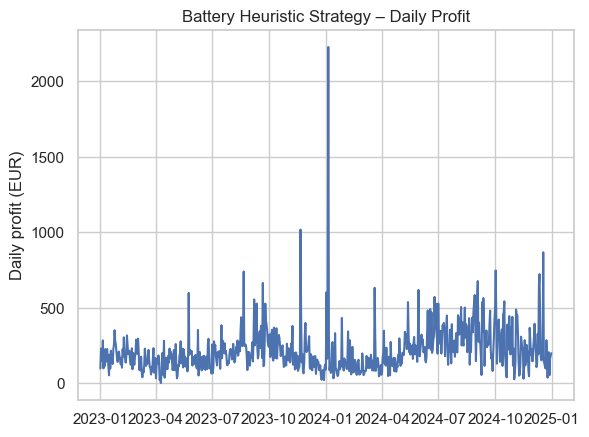

In [100]:

def heuristic_daily_profit(df, charge_hours=2, discharge_hours=2, eff=0.92):
    profits = []
    for d, group in df.groupby('date'):
        cheapest = group.nsmallest(charge_hours, 'price_EUR_MWh')
        priciest = group.nlargest(discharge_hours, 'price_EUR_MWh')
        # revenue = sell – buy (consider round‑trip efficiency)
        sell = priciest['price_EUR_MWh'].sum() * (1*eff)
        buy = cheapest['price_EUR_MWh'].sum() / eff
        profits.append(sell - buy)
    return pd.Series(profits, index=df['date'].unique())

daily_profit = heuristic_daily_profit(day_prices_df)
print('Heuristic annual profit €', daily_profit.sum().round(0))

daily_profit.plot()
plt.ylabel('Daily profit (EUR)')
plt.title('Battery Heuristic Strategy – Daily Profit')
plt.show()


### 2 B. Optimal Day Schedule with Perfect Forecast

In [101]:

def perfect_daily_profit(df, cycles=2, eff=0.92):
    profits = []
    for d, g in df.groupby('date'):
        h_sorted = g.sort_values('price_EUR_MWh')
        charge = h_sorted.head(cycles)
        discharge = h_sorted.tail(cycles)
        sell = discharge['price_EUR_MWh'].sum() * eff
        buy = charge['price_EUR_MWh'].sum() / eff
        profits.append(sell - buy)
    return pd.Series(profits, index=df['date'].unique())

perfect_profit = perfect_daily_profit(day_prices_df)
print('Perfect‑info annual profit €', perfect_profit.sum().round(0))


Perfect‑info annual profit € 157973.0


### 2 C. Full‑Year Optimization with Perfect Foresight

In [ ]:
# ============================================================
# FIXED MILP OPTIMIZATION
# ============================================================

try:
    from pulp import LpProblem, LpVariable, LpBinary, lpSum, LpMaximize
    USE_PULP = True
except ImportError:
    print("⚠️  PuLP not installed. Skipping MILP optimization.")
    USE_PULP = False

if USE_PULP:
    # Filter for January 2024 - but handle timestamp as datetime, not string
    jan_2024 = day_prices_df[
        (day_prices_df['timestamp'].dt.year == 2024) & 
        (day_prices_df['timestamp'].dt.month == 1)
    ].copy()
    
    if len(jan_2024) > 0:
        n = len(jan_2024)
        price = jan_2024['price_EUR_MWh'].values
        prob = LpProblem('BatteryOptimization', LpMaximize)
        charge = LpVariable.dicts('ch', range(n), 0, 1)
        discharge = LpVariable.dicts('dis', range(n), 0, 1)
        
        # Objective
        prob += lpSum([(discharge[t] * price[t] * 0.92) - (charge[t]*price[t]/0.92) for t in range(n)])
        
        # SOC constraints with proper tracking
        soc_vars = LpVariable.dicts('soc', range(n+1), 0, 2)
        prob += soc_vars[0] == 0  # Start empty
        
        for t in range(n):
            prob += soc_vars[t+1] == soc_vars[t] + charge[t] - discharge[t]
            prob += charge[t] + discharge[t] <= 1  # Can't charge and discharge simultaneously
        
        prob.solve()
        
        if prob.status == 1:  # Optimal solution found
            monthly_profit = sum([
                (discharge[t].value() or 0)*price[t]*0.92 - 
                (charge[t].value() or 0)*price[t]/0.92 
                for t in range(n)
            ])
            print(f'Monthly profit (Jan 2024): €{monthly_profit:.2f}')
        else:
            print("MILP optimization failed")
    else:
        print("No January 2024 data found")



# # Sketch of mixed‑integer linear programming approach using pulp
# from pulp import LpProblem, LpVariable, LpBinary, lpSum, LpMaximize

# # To keep runtime reasonable in demo, we optimize a single month
# month_df = day_prices_df[day_prices_df['timestamp'].str.startswith('2024-01')]
# n = len(month_df)
# price = month_df['price_EUR_MWh'].values
# prob = LpProblem('BatteryOptimization', LpMaximize)
# charge = LpVariable.dicts('ch', range(n), 0, 1)  # 1 MWh steps
# discharge = LpVariable.dicts('dis', range(n), 0, 1)

# # Objective
# prob += lpSum([(discharge[t] * price[t] * 0.92) - (charge[t]*price[t]/0.92) for t in range(n)])

# # SOC constraints
# soc = 0
# for t in range(n):
#     soc += charge[t] - discharge[t]
#     prob += soc <= 2
#     prob += soc >= 0
#     # cycles cap: ≤2 per day handled approximately by limiting energy moved
# prob.solve()
# print('Monthly profit (Jan) €', sum([(discharge[t].value()*price[t]*0.92) - 
#                                      (charge[t].value()*price[t]/0.92) for t in range(n)]))


Scaling the above MILP to the full year may require aggregation or rolling‑horizon techniques to keep the problem tractable.

## Part III – Consumer Reaction to Price <a id='Part-III'></a>

### 3 A. National‑Level Demand Elasticity

In [ ]:

nat_cons_df['timestamp'] = pd.to_datetime(nat_cons_df['timestamp'])
nat_cons_df = nat_cons_df.merge(day_prices_df[['timestamp','price_EUR_MWh']],
                                on='timestamp', how='left')
nat_cons_df = nat_cons_df.merge(meteo_df[['time','avg_temperature','avg_ghi']],
                                left_on=nat_cons_df['timestamp'].dt.floor('H'),
                                right_on='time', how='left').drop(columns=['key_0'])
nat_cons_df['log_demand'] = np.log(nat_cons_df['demand_MWh'])
nat_cons_df['log_price'] = np.log(nat_cons_df['price_EUR_MWh'])

X = sm.add_constant(nat_cons_df[['log_price','avg_temperature']])
y = nat_cons_df['log_demand']
nat_model = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':24})
print(nat_model.summary())

elasticity = nat_model.params['log_price']
print('Estimated price elasticity:', elasticity)


### 3 B. Object‑Level Panel Regression

In [ ]:

# Aggregate hourly price/weather
hour_ref = day_prices_df[['timestamp','price_EUR_MWh']].copy()
hour_ref['timestamp'] = pd.to_datetime(hour_ref['timestamp'])
meteo_df['time'] = pd.to_datetime(meteo_df['time'])
hour_ref = hour_ref.merge(meteo_df, left_on='timestamp', right_on='time', how='left').drop(columns=['time'])

obj_cons_df['consumptionTime'] = pd.to_datetime(obj_cons_df['consumptionTime'])
panel = obj_cons_df.merge(hour_ref, left_on='consumptionTime', right_on='timestamp', how='left')
panel['log_cons'] = np.log(panel['amount']+1e-6)
panel['log_price'] = np.log(panel['price_EUR_MWh'])
panel['hour'] = panel['consumptionTime'].dt.hour
# Fixed‑effects via within transformation using statsmodels
import linearmodels as lm
panel.set_index(['objectNumber','consumptionTime'], inplace=True)

fe_mod = lm.PanelOLS.from_formula('log_cons ~ 1 + log_price + avg_temperature + EntityEffects + TimeEffects',
                                  data=panel)
fe_res = fe_mod.fit(cov_type='clustered', cluster_entity=True)
print(fe_res.summary)


### 3 C. Visualising Behavioural Shifts

In [ ]:

sns.scatterplot(data=panel.sample(10000), x='price_EUR_MWh', y='amount', alpha=0.2)
plt.xscale('log'); plt.yscale('log')
plt.title('Sample Object‑Level Demand vs Price')
plt.xlabel('Price (EUR/MWh)')
plt.ylabel('Consumption (kWh)')
plt.show()


## Conclusions <a id='Conclusions'></a>
*Summarise key insights, profitability ranges, and policy implications here.*